<h1> Build with Llama API </h1>


This notebook introduces you to the functionality offered by Llama API, so that you can get up and running with the latest Llama 4 models quickly and efficiently.

## Running this notebook

To run this notebook, you'll need to sign up for a Llama API developer account at [llama.developer.meta.com](https://llama.developer.meta.com) and get an API key. You'll also need to have Python 3.8+ and a way to install the Llama API Python SDK such as [pip](https://pip.pypa.io/en/stable/).

### Installing the Llama API client for Python

The [Llama API client for Python](https://github.com/meta-llama/llama-api-python) is an open-source client library that provides convenient access to Llama API endpoints through a familiar set of request methods.

Install the SDK using pip.

In [ ]:
%pip install llama-api-client

### Getting and setting up an API key

Sign up for, or log in to, a Llama API developer account at [llama.developer.meta.com](https://llama.developer.meta.com), then navigate to the **API keys** tab in the dashboard to create a new API key.

Assign your API key to the environment variable `LLAMA_API_KEY`.

In [4]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv(os.path.expanduser("~/.env"))
LLAMA_API_KEY = os.getenv("LLAMA_API_KEY")
os.environ["LLAMA_API_KEY"] = LLAMA_API_KEY
print(LLAMA_API_KEY[:4]+"...")

LLM|...


Now you can import the SDK and instantiate it. The SDK will automatically pull the API key from the environment variable set above.

In [5]:
from llama_api_client import LlamaAPIClient
client = LlamaAPIClient()

## Your first API call

With the SDK set up, you're ready to make your first API call. 

Start by checking the list of available models:

In [6]:
models = client.models.list()
for model in models:
    print(model.id)

Llama-3.3-70B-Instruct
Llama-3.3-8B-Instruct
Llama-4-Maverick-17B-128E-Instruct-FP8
Llama-4-Scout-17B-16E-Instruct-FP8
dev-llama4-17b-hybrid_speech_mp2
dev-llama4-17b-realtime-speech-test
dev-llama-4-17B-reasoning-latest
Llama-4-Reasoning-17B-128E-Instruct-FP8


The list of models may change in accordance with model releases. This notebook will use the latest Llama 4 model: `Llama-4-Maverick-17B-128E-Instruct-FP8`.

## Image grounding

Use the [chat completions](https://llama.developer.meta.com/docs/api/chat) endpoint for questions about the image on the example of object detection with user prompt

View the image before sending it to the API

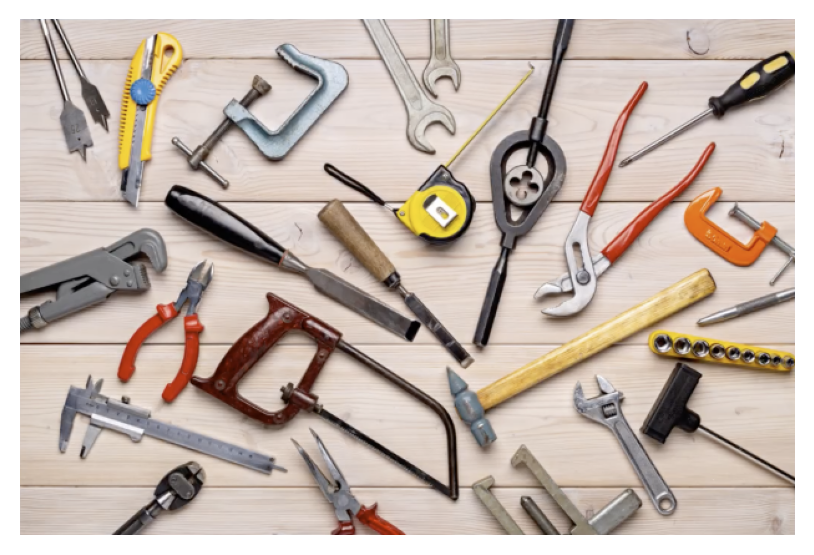

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import base64

def display_local_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(5,4), dpi=200)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def encode_image(image_path):
  with open(image_path, "rb") as img:
    return base64.b64encode(img.read()).decode('utf-8')

img_path = "../src/docs/img/ruler_example.png"  
display_local_image(img_path)
base64_image = encode_image(img_path)

Ask the question like https://www.llama.com/ official website promotes:

In [12]:
def generate_response(prompt, base64_image, model="Llama-4-Scout-17B-16E-Instruct-FP8", t=0.1):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt,
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            },
        ],
        temperature=t,
    )
    return response.completion_message.content.text

In [13]:
prompt = "Which tools in the image can be used for measuring length? Provide bounding boxes for every recognized item."
base64_image = encode_image(img_path)
model = "Llama-4-Scout-17B-16E-Instruct-FP8"
output = generate_response(prompt, base64_image, model)
output

'The tools in the image that can be used for measuring length are:\n\n*   **Tape measure**: <BBOX>0.485,0.000,0.600,0.499</BBOX>. \n*   **Ruler**: <BBOX>0.131,0.728,0.369,0.937</BBOX>.'

Visualize the outputs on the image. This example uses [Pydantic](https://pydantic.dev/) schema. You may need to install pydantic to run this example.

In [20]:
import re
from pydantic import BaseModel
from typing import List
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class BoundingBox(BaseModel):
    x1: float
    y1: float
    x2: float
    y2: float

class Detection(BaseModel):
    name: str = ""
    bbox: BoundingBox

def parse_output(output: str) -> List[Detection]:
    lines = output.split('\n')
    detections = []
    
    for line in lines:
        match = re.search(r'<BBOX>(.*?)</BBOX>', line)
        if match:
            parts = line.split(':')
            if len(parts) > 1:
                name = parts[0].strip().replace('*', '').strip()
            else:
                name = ""
            
            x1, y1, x2, y2 = map(float, match.group(1).split(','))
            detections.append(Detection(name=name, bbox=BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)))
    
    return detections

def draw_bounding_boxes(img_path: str, detections: List[Detection], color='green') -> None:
    img = Image.open(img_path)
    width, height = img.size
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    for detection in detections:
        rect = patches.Rectangle((detection.bbox.x1 * width, detection.bbox.y1 * height), 
                                 (detection.bbox.x2 - detection.bbox.x1) * width, 
                                 (detection.bbox.y2 - detection.bbox.y1) * height, 
                                 linewidth=1, edgecolor=color, facecolor='none')
        
        ax.add_patch(rect)
        if detection.name:
            ax.text(detection.bbox.x1 * width, detection.bbox.y1 * height, 
                    detection.name, color=color, bbox=dict(facecolor='white', alpha=0.7))
        else:
            ax.text(detection.bbox.x1 * width, detection.bbox.y1 * height, 
                    f"Detection {detections.index(detection)+1}",
                    color=color, bbox=dict(facecolor='white', alpha=0.7))

    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

The tools in the image that can be used for measuring length are:

*   **Tape measure**: <BBOX>0.482,0.007,0.653,0.569</BBOX>. 
*   **Ruler**: <BBOX>0.106,0.748,0.357,0.897</BBOX>.


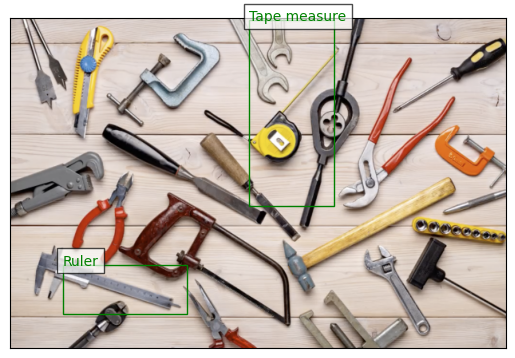

In [21]:
output = generate_response(prompt, base64_image, model, t=0.2)
print(output)
detections = parse_output(output)
draw_bounding_boxes(img_path, detections)